In [1]:
from haplogone import VCF

In [2]:
sample = VCF("../../bioinf_semester_project/vcf_dels/er_chr1.vcf")
sample.read().count_baf().segment_baf()
sample

VCF(
	input_file='../../bioinf_semester_project/vcf_dels/er_chr1.vcf',
	path_to_centromeres_file='centromeres.bed',
	segment_size_threshold=1000000.0,
	segmentation_shuffles=1000,
	segmentation_p=0.01,
	validation_shuffles=1000,
	validation_p=0.01
)

In [3]:
sample.vcf

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,AC,AF,AN,...,QD,ReadPosRankSum,SOR,CSQ,GT,AD,GQ,PL,BAF,BAF_segment
0,chr1,611317,rs12025928,A,G,3469.06,.,2,1.00,2,...,27.32,0.445,2.746,G|upstream_gene_variant|MODIFIER|LOC105378947|...,1/1,[93],99,"3483,239,0",1.000000,0.781396
1,chr1,923421,rs7418179,A,G,2978.06,.,2,1.00,2,...,33.48,NaN,0.941,G|upstream_gene_variant|MODIFIER|SAMD11|148398...,1/1,[70],99,"2992,211,0",1.000000,0.781396
2,chr1,924024,rs71509444,C,G,919.06,.,2,1.00,2,...,28.72,NaN,1.112,G|5_prime_UTR_variant|MODIFIER|SAMD11|148398|T...,1/1,[32],96,"933,96,0",1.000000,0.781396
3,chr1,924310,rs71509445,C,G,1226.06,.,2,1.00,2,...,35.63,NaN,2.226,G|5_prime_UTR_variant|MODIFIER|SAMD11|148398|T...,1/1,[29],87,"1240,87,0",1.000000,0.781396
4,chr1,924321,rs71509446,C,G,1175.06,.,2,1.00,2,...,33.12,NaN,1.071,G|5_prime_UTR_variant|MODIFIER|SAMD11|148398|T...,1/1,[29],87,"1189,87,0",1.000000,0.781396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6775,chr1,248682170,rs4575113,T,C,3335.06,.,2,1.00,2,...,25.30,NaN,0.788,C|synonymous_variant|LOW|OR14I1|401994|Transcr...,1/1,[86],99,"3349,258,0",1.000000,0.821584
6776,chr1,248682198,rs4462184,A,G,2856.06,.,2,1.00,2,...,28.08,1.649,1.308,G|missense_variant|MODERATE|OR14I1|401994|Tran...,1/1,[78],99,"2870,197,0",1.000000,0.821584
6777,chr1,248745207,.,T,C,2477.06,.,2,1.00,2,...,31.70,NaN,0.811,C|missense_variant|MODERATE|LYPD8|646627|Trans...,1/1,[70],99,"2491,210,0",1.000000,0.821584
6778,chr1,248750448,.,C,A,575.06,.,2,1.00,2,...,29.43,NaN,5.549,A|intron_variant|MODIFIER|LYPD8|646627|Transcr...,1/1,[15],45,"589,45,0",1.000000,0.821584


In [4]:
sample.create_bed()

,#chrom,chromStart,chromEnd,name
0,chr1,228372438,242524088,LOH


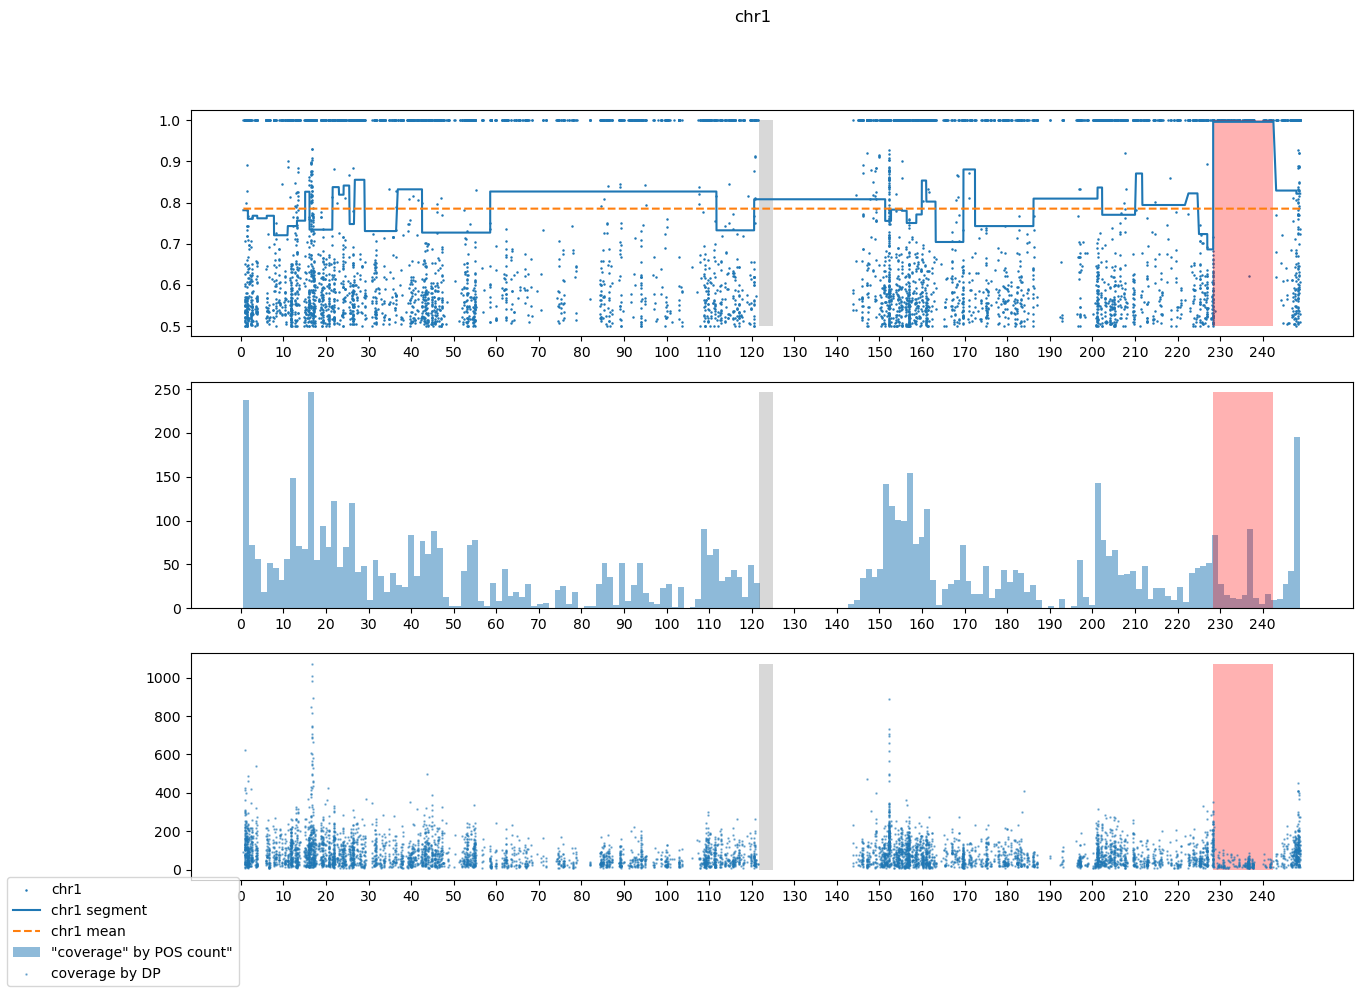

In [5]:
sample.plot_chromosomes()